In [1]:

#------------------------------------------------------------------------------------------------
#  Licensed under the MIT License. See License.txt in the project root for license information.
#------------------------------------------------------------------------------------------------

DMD_steady-state_Dary-scale.py

# Fig. 3-5 from Spurin et al. Dynamic Mode Decomposition for Analyzing Dynamics in Multi-phase Flow in Porous Media ... paper


Dynamic Mode Decomposition of Core Flooding Experiments in Special Core Analysis (SCAL)
                        

Created on Thu Nov 19 09:53:58 2020

analyze pressure fluctuations in steady-state data

use primary drainage (brine-decane) in water-wet Fontainebleau sandstone data set
Fig. 1 from SCA2015-007   /  Fig. 6 from Ruecker et al. Frontiers in Water 3, 671399, 2021

Data is contained in Excel spread sheet
     pressure data     FB_HS_1_Steady-State_fw-dp.xlsx
     saturation data   FB_HS_1_Steady-State_Sw.xlsx


@author: Steffen.Berg

In [2]:

# ---
# jupyter:
#   jupytext:
#     formats: ipynb,py:percent
#     text_representation:
#       extension: .py
#       format_name: percent
#       format_version: '1.3'
#       jupytext_version: 1.13.0
#   kernelspec:
#     display_name: Python 3
#     language: python
#     name: python3
# ---

# Classical analysis 

# Loading time series data into data frame

In [3]:


import numpy as np
from scipy import interpolate
from scipy import fftpack
from scipy.signal import blackman

from scipy.optimize import curve_fit

import matplotlib.pyplot as plt

import pandas as pd

from scipy.signal import find_peaks, peak_prominences



# read Excel sheet into Pandas data frame


filename='FB_HS_1_Steady-State_fw-dp.xlsx'
#filename='test.xlsx'

data = pd.read_excel(filename,skiprows=[1,2])

# uncomment to print data
# print(data)
# print(data.columns)

# inspecting the Excel sheet --> there are multiple cycles, first cycle is [0:9470]
df=pd.DataFrame(data, columns= ['date','fw','PVinjected','dPwro'])[0:5510]



Swfilename='FB_HS_1_Steady-State_Sw.xlsx'
Swdata = pd.read_excel(Swfilename)

# uncomment to print data
# print(Swdata)
# print(Swdata.columns)

dfSw=pd.DataFrame(Swdata, columns= ['datetime', 'fw', 'PV','Sw','R'])

# Make overview plot

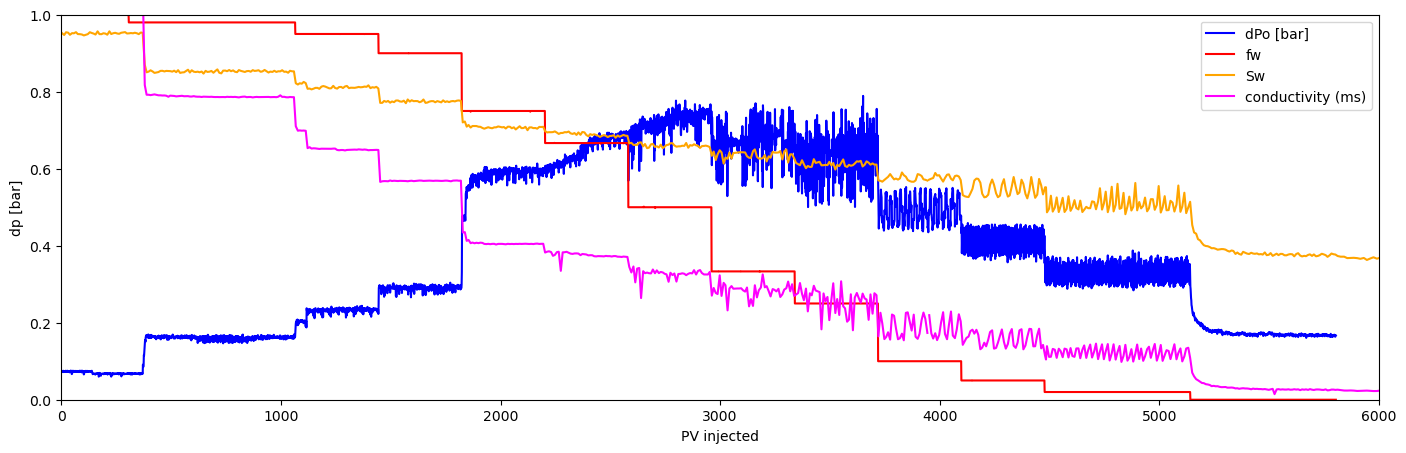

In [4]:

# compute time difference in seconds as 
#print((df.date[1]-df.date[0]).seconds)

#datadate1=datadate.astype('datetime64[ns]')

plt.figure(figsize=(17, 5))
plt.plot(df.PVinjected, df.dPwro, '-', color='blue', label='dPo [bar]')
plt.plot(df.PVinjected, df.fw, '-', color='red', label='fw')
plt.plot(dfSw.PV, dfSw.Sw, '-', color='orange', label='Sw')
plt.plot(dfSw.PV, 1/dfSw.R*1000, '-', color='magenta', label='conductivity (ms)')
#plt.plot(dfSw.PV, dfSw.fw, '--', color='red', label='fw (Sw data)')
#plt.xlim(0,1)
#plt.ylim(0,1)
plt.axis([0, 6000, 0, 1])
plt.legend();
plt.xlabel('PV injected'); plt.ylabel('dp [bar]')
#plt.title('Relative Permeability');
plt.show()



# moving average for baseline computation
avwindow = 40

# moving average function, need to fiddle a bit with upper and lower bounds
def movingaverage(xvalues,yvalues,avwindow):
   xav=[xvalues[0]]
   yav=[sum(yvalues[0:avwindow // 4])/(avwindow // 4)]

   for i in range(len(xvalues)-avwindow):
     xav.append(sum(xvalues[i:i+avwindow])/avwindow)
     yav.append(sum(yvalues[i:i+avwindow])/avwindow)
     
   xav.append(xvalues[len(xvalues)-1])
   yav.append(sum(yvalues[len(xvalues)-avwindow-1:len(xvalues)-1])/avwindow)
   return xav, yav

# bins for histogram
nbins=20




# Decomposition into individual fractional flow (fw) intervals, select fw=0.1

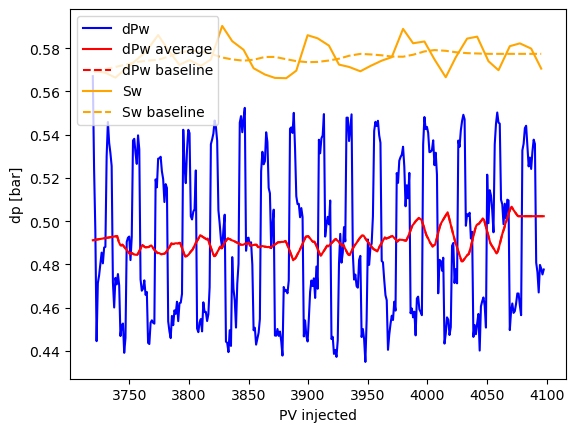

In [5]:


fwlist = [1.0, 0.98, 0.95, 0.90, 0.75, 0.67, 0.50, 0.33, 0.25, 0.10, 0.05, 0.02, 0.00]

# select fw=0.1

fwact = 0.1

df1=df.where((df.fw < fwact + 0.01) & (df.fw > fwact - 0.01) & (df.PVinjected>0)).dropna()

# for fw=0.98 need to crop first part of the time series

if fwact == 0.98:
    df1=df1[80:len(df1)]

xav, yav = movingaverage(df1.PVinjected.values, df1.dPwro.values, avwindow)

# generate baseline by re-interpolating with PV 
interpfun1=interpolate.interp1d(xav, yav)
baseline=interpfun1(df1.PVinjected.values[0:len(df1.PVinjected.values)])
noise=df1.dPwro-baseline

# compute differential time 
dt=np.arange(0,1,1/len(df1.index))
for i in range(len(df1.index)):
    dt[i] = (df1.date[df1.index[i]]-df1.date[df1.index[0]]).seconds


df1['baseline']=baseline
df1['noise']=noise
df1['dt']=dt


# do the same for the Sw data
df1Sw=dfSw.where((dfSw.fw < fwact + 0.01) & (dfSw.fw > fwact - 0.01) & (dfSw.PV>0)).dropna()

if fwact == 0.98:
    df1Sw=df1Sw[10:len(df1)]

Swxav, Swyav = movingaverage(df1Sw.PV.values, df1Sw.Sw.values, avwindow//4)

# generate baseline by re-interpolating with PV 
interpfun1Sw=interpolate.interp1d(Swxav, Swyav)
baselineSw=interpfun1Sw(df1Sw.PV.values[0:len(df1Sw.PV.values)])
noiseSw=df1Sw.Sw-baselineSw

# compute differential time 
dtSw=np.arange(0,1,1/len(df1Sw.index))
for i in range(len(df1Sw.index)):
    dtSw[i] = (df1Sw.datetime[df1Sw.index[i]]-df1Sw.datetime[df1Sw.index[0]]).seconds

df1Sw['baseline']=baselineSw
df1Sw['noise']=noiseSw
df1Sw['dt']=dtSw


# plot dp for fw plateau and baseline
plt.plot(df1.PVinjected, df1.dPwro, '-', color='blue', label='dPw')
plt.plot(xav, yav, '-', color='red', label='dPw average')
plt.plot(df1.PVinjected,baseline, '--', color='red', label='dPw baseline')
plt.plot(df1Sw.PV, df1Sw.Sw, '-', color='orange', label='Sw')
plt.plot(df1Sw.PV, baselineSw, '--', color='orange', label='Sw baseline')
plt.legend();
plt.xlabel('PV injected'); plt.ylabel('dp [bar]')
plt.show()




# Compute and Plot histograms

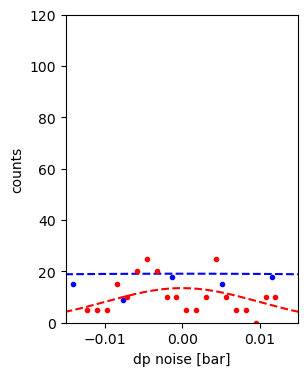

In [6]:

# compute histograms

dpnoisemin = np.min(df1.noise)
dpnoisemax = np.max(df1.noise)
dpnoisehistbins = np.arange(dpnoisemin,dpnoisemax,(dpnoisemax-dpnoisemin)/(nbins+1))
dpnoisehist, dpnoisebin_edges = np.histogram(df1.noise, bins=dpnoisehistbins, density=False)
dpnoisehistmax = np.max(dpnoisehist)

def gaus(x,a,x0,sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

dpparams0 = [dpnoisehistmax,0,((dpnoisemax-dpnoisemin)/2)]
dpstdevest = (dpnoisemax-dpnoisemin)/2
#bounds = [(20,40),(dpnoisemin/2,dpnoisemax/2),(0.5*stdevest,1.5*stdevest)]
#dpbounds = [(0,-1E-5,0.001),(2*dpnoisehistmax,1E-5,0.2)]
dpbounds = [(0,-1E-5,0.001),(2*dpnoisehistmax,1E-5,0.1)]

dppopt,dppcov = curve_fit(gaus,dpnoisebin_edges[0:nbins], dpnoisehist,dpparams0,bounds=dpbounds)
dpnoisegaussx=np.arange(-0.22, 0.22, 1/2000)
dpnoisegaussy=gaus(dpnoisegaussx,dppopt[0],dppopt[1],dppopt[2])


Swnoisemin = np.min(df1Sw.noise)
Swnoisemax = np.max(df1Sw.noise)
Swnoisehistbins = np.arange(Swnoisemin,Swnoisemax,(Swnoisemax-Swnoisemin)/(nbins+1))
Swnoisehist, Swnoisebin_edges = np.histogram(df1Sw.noise, bins=Swnoisehistbins, density=False)
Swnoisehistmax = np.max(Swnoisehist)

Swparams0 = [Swnoisehistmax,0,((Swnoisemax-Swnoisemin)/2)]
Swstdevest = (Swnoisemax-Swnoisemin)/2
#bounds = [(20,40),(dpnoisemin/2,dpnoisemax/2),(0.5*stdevest,1.5*stdevest)]
Swbounds = [(0,-1E-5,0.001),(2*Swnoisehistmax,1E-5,0.1)]

Swpopt,Swpcov = curve_fit(gaus,Swnoisebin_edges[0:nbins], Swnoisehist,Swparams0,bounds=Swbounds)
Swnoisegaussx=np.arange(-0.22, 0.22, 1/2000)
Swnoisegaussy=gaus(Swnoisegaussx,Swpopt[0],Swpopt[1],Swpopt[2])

plt.figure(figsize=(3, 4))
plt.plot(dpnoisebin_edges[0:nbins], dpnoisehist, '.', color='blue', label='dp noise')
plt.plot(dpnoisegaussx,dpnoisegaussy, '--', color='blue', label='Gaussian')
plt.plot(Swnoisebin_edges[0:nbins], 5*Swnoisehist, '.', color='red', label='Sw noise')
plt.plot(Swnoisegaussx,5*Swnoisegaussy, '--', color='red', label='Gaussian')
plt.xlabel('dp noise [bar]'); plt.ylabel('counts')
plt.axis([-0.015, 0.015, 0, 120])
plt.show()




# Compute and FFT, identify dominant peaks

C:\Users\Steffen.Berg\AppData\Local\Temp\ipykernel_25096\1273649721.py:21: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  peaksarrsort = np.sort(peaksarrnp.view('f8,f8'), order=['f1'], axis=0).view(np.float)[::-1]


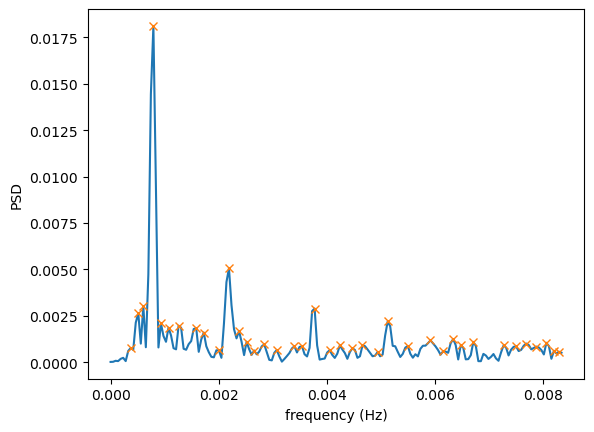

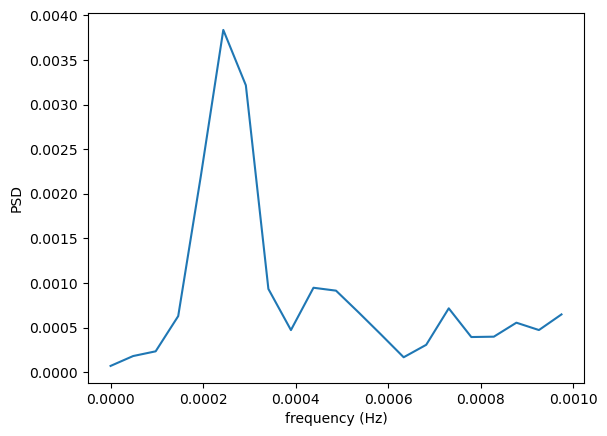

In [7]:

# compute FFT
N=len(df1.noise.values)
w = blackman(N)
yf = fftpack.fft(w*df1.noise.values)
yfabs=2.0/N*np.abs(yf)
T = df1.dt[df1.dt.index[1]]-df1.dt[df1.dt.index[0]]
N = len(df1.noise.values)
xf = np.linspace(0.0, 1.0/(2.0*T), N//2)


# find peaks
peaks, properties = find_peaks(yfabs[:N//2], height=5E-4)
prominences = peak_prominences(yfabs, peaks)[0]

# sort peaks
peaksarr = []
for i in peaks:
    peaksarr.append([xf[i],yfabs[i]])
peaksarrnp = np.array(peaksarr)

peaksarrsort = np.sort(peaksarrnp.view('f8,f8'), order=['f1'], axis=0).view(np.float)[::-1]



plt.plot(xf,yfabs[:N//2])
plt.plot(xf[peaks], yfabs[peaks], "x")
#plt.plot(np.zeros_like(xf), "--", color="gray")
plt.xlabel('frequency (Hz)'); plt.ylabel('PSD')
plt.show()


NSw=len(df1Sw.noise.values)
wSw = blackman(NSw)
yfSw = fftpack.fft(wSw*df1Sw.noise.values)
TSw = df1Sw.dt[df1Sw.dt.index[1]]-df1Sw.dt[df1Sw.dt.index[0]]
NSw = len(df1Sw.noise.values)
xfSw = np.linspace(0.0, 1.0/(2.0*TSw), NSw//2)


plt.plot(xfSw,2.0/NSw * np.abs(yfSw[:NSw//2]))
#plt.plot(np.zeros_like(xf), "--", color="gray")
plt.xlabel('frequency (Hz)'); plt.ylabel('PSD')
plt.show()




# Make summary plot for fw=0.1

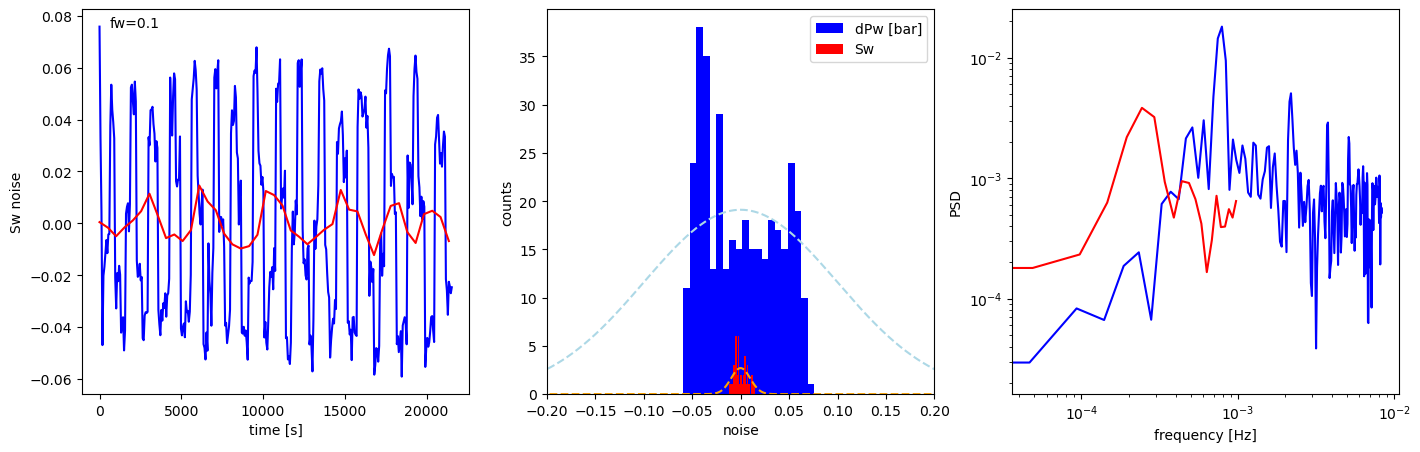

In [8]:


# mean and standard deviation
dpmean=np.mean(df1.dPwro.values)
dpstd=np.std(df1.noise.values)

Swmean=np.mean(df1Sw.Sw.values)
Swstd=np.std(df1Sw.noise.values)


#dtmaxt = 12000
dtminp = -0.22
dtmaxp = 0.22
dtcountmax = 100

fig, axs = plt.subplots(nrows = 1, ncols=3, figsize=(17, 5))
axs[0].plot(df1.dt, df1.noise, '-', color='blue', label='dPw')
axs[0].set_xlabel('time [s]')
axs[0].set_ylabel('dpw noise [bar]')
axs[0].plot(df1Sw.dt, df1Sw.noise, '-', color='red', label='dPw')
axs[0].set_xlabel('time [s]')
axs[0].set_ylabel('Sw noise')
#axs[0].set(xlim=(0, dtmaxt), ylim=(dtminp, dtmaxp))
#axs[0].set(ylim=(dtminp, dtmaxp))
#axs[0].set_title('fw='+str(fwact))
axs[0].annotate('fw='+str(fwact), (max(df1.dt.values)//10,max(df1.noise.values)), ha='center')


axs[1].hist(df1.noise, nbins, color='blue', label='dPw [bar]')
axs[1].plot(dpnoisegaussx,dpnoisegaussy, '--', color='lightblue')
axs[1].hist(df1Sw.noise, nbins, color='red', label='Sw')
axs[1].plot(Swnoisegaussx,Swnoisegaussy, '--', color='orange')
axs[1].set_xlabel('noise')
axs[1].set_ylabel('counts')
#axs[1].set(xlim=(dtminp, dtmaxp), ylim=(0, dtcountmax))
axs[1].set(xlim=(-0.20, 0.20))
axs[1].legend()

axs[2].loglog(xf, 2.0/N * np.abs(yf[:N//2]), '-', color='blue', label='dPw')
axs[2].loglog(xfSw, 2.0/NSw * np.abs(yfSw[:NSw//2]), '-', color='red', label='Sw')
axs[2].set_xlabel('frequency [Hz]')
axs[2].set_ylabel('PSD')
#axs[2].set(xlim=(dtfmin, dtfmax), ylim=(dtfpmin, dtfpmax))

plt.show()




# Space-Time plots of Saturation Profile Data

In [9]:

# read saturation profiles from Excel file


swproffilename='FB_HS_1_Steady-State_fw=01_swdata.xlsx'
#filename='test.xlsx'

swprofiledata = pd.read_excel(swproffilename,skiprows=[0,1])
# uncomment to print data
# print(swprofiledata)
# print(swprofiledata.columns)

# inspecting the Excel sheet --> there are multiple cycles, first cycle is [0:9470]
dfswprofile=pd.DataFrame(swprofiledata)

# plot first 13 profiles into 1 plot, vertically shift profiles for clarity

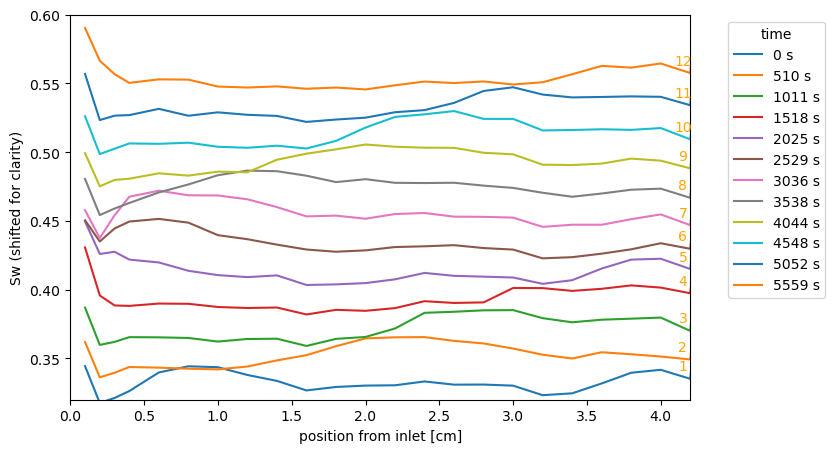

In [10]:

maxswprof=12
plt.figure(figsize=(8, 5))
for i in range(2,maxswprof+2):
  #plt.plot(dfswprofile.cm, dfswprofile[dfswprofile.columns[i]], '-', label=str(dfswprofile.columns[i]) +' s')
  plt.plot(dfswprofile.cm, (i-4)*0.02+dfswprofile[dfswprofile.columns[i]], '-', label=str(dfswprofile.columns[i]) +' s')
  plt.annotate(str(i-1), (4.15,0.006+(i-4)*0.02+dfswprofile[dfswprofile.columns[i]][22]), ha='center', color='orange')
plt.xlim(0,4.2)
#plt.ylim(0,1)
plt.axis([0, 4.2, 0.32, 0.60])
#plt.legend(loc='upper right');
plt.legend(title='time', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('position from inlet [cm]'); plt.ylabel('Sw (shifted for clarity)')
#plt.title('Relative Permeability');
plt.show()

# plot pressure drop and average saturation over same time interval

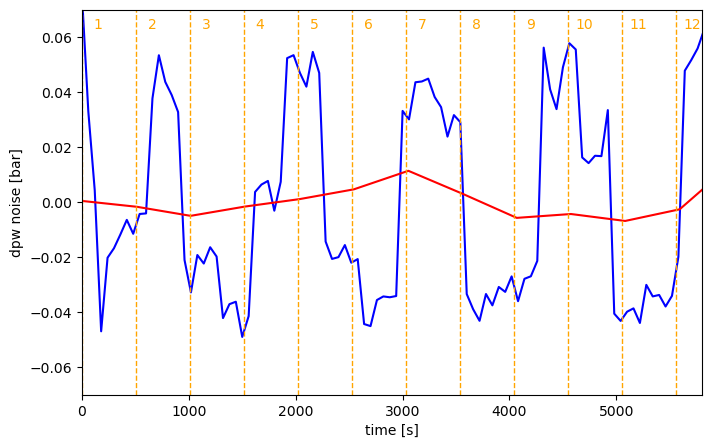

In [11]:

plt.figure(figsize=(8, 5))
plt.plot(df1.dt, df1.noise, '-', color='blue', label='dPw')
plt.xlabel('time [s]')
plt.ylabel('dpw noise [bar]')
plt.plot(df1Sw.dt, df1Sw.noise, '-', color='red', label='Sw')
plt.axis([0, 5800,-0.07, 0.07])
for i in range(0,maxswprof):
   plt.vlines(dfswprofile.columns[i+2],ymin=-0.07,ymax=0.07,linestyle='dashed',colors='orange', linewidth=1)
   plt.annotate(str(i+1), (dfswprofile.columns[i+2]+150,0.063), ha='center', color='orange')
plt.show()




# Space-Time Contour Plot of Saturation

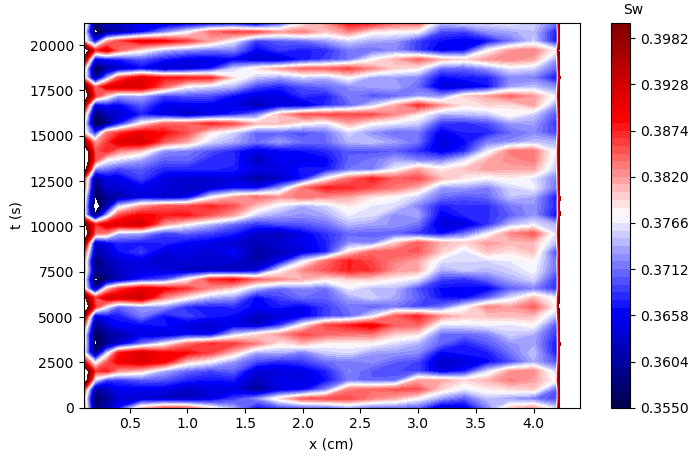

In [12]:

xlist=np.array(dfswprofile.cm)
tlistmax=len(dfswprofile.columns)
tlist=np.linspace(dfswprofile.columns[2],dfswprofile.columns[tlistmax-1],tlistmax-2)


X, Y = np.meshgrid(xlist, tlist)
Z = np.sqrt(X**2 + Y**2)

for i in range(0,tlistmax-2):
    for ii in range(0,len(dfswprofile[dfswprofile.columns[i+2]])):
        Z[i,ii]=dfswprofile[dfswprofile.columns[i+2]][ii]

levels=np.linspace(0.355,0.40,51)

fig, ax = plt.subplots(nrows = 1, ncols=1, figsize=(8,5))
#cp = ax.contourf(X, Y, Z,50,cmap='plasma')
cp = ax.contourf(X, Y, Z,levels,cmap='seismic')
#ax.grid(c='k', ls='-', alpha=0.3)
clb=fig.colorbar(cp) # Add a colorbar to a plot
clb.set_label('Sw', labelpad=-40, y=1.05, rotation=0)
#ax.set_title('Filled Contours Plot')
ax.set_xlabel('x (cm)')
ax.set_ylabel('t (s)')
plt.show()




# DMD Analysis

In [13]:


from pydmd import DMD
from pydmd import MrDMD

# Plot original data without smoothing 

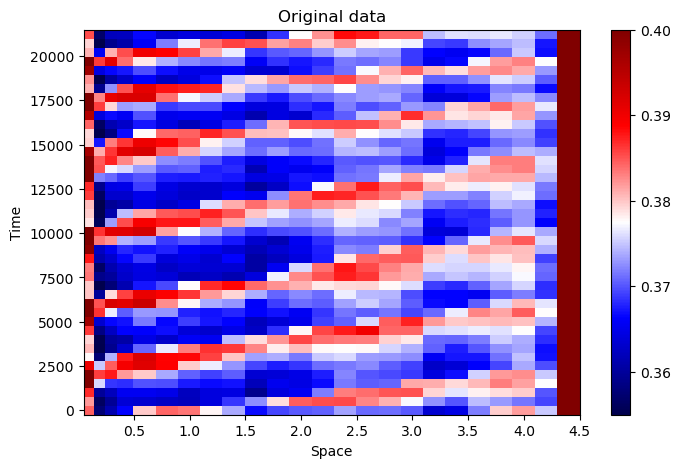

In [14]:

def make_plot(X, x=None, y=None, figsize=(8, 5), title=''):
    """
    Plot of the data X
    """
    plt.figure(figsize=figsize)
    plt.title(title)
    X = np.real(X)
    CS = plt.pcolor(x, y, X, vmin=0.355, vmax=0.40, cmap='seismic')
    cbar = plt.colorbar(CS)
    plt.xlabel('Space')
    plt.ylabel('Time')
    plt.vmin=0.355
    plt.vmax=0.40
    plt.show()
    
data=Z.T    
    
make_plot(data.T, x=xlist, y=tlist, title='Original data')



# First we apply the classical DMD without svd rank truncation

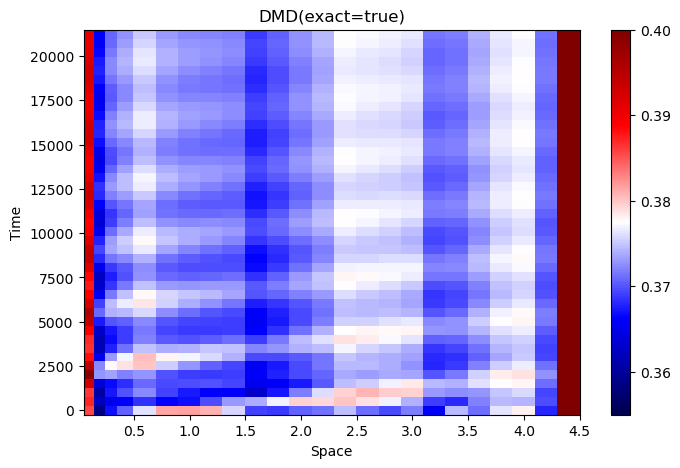

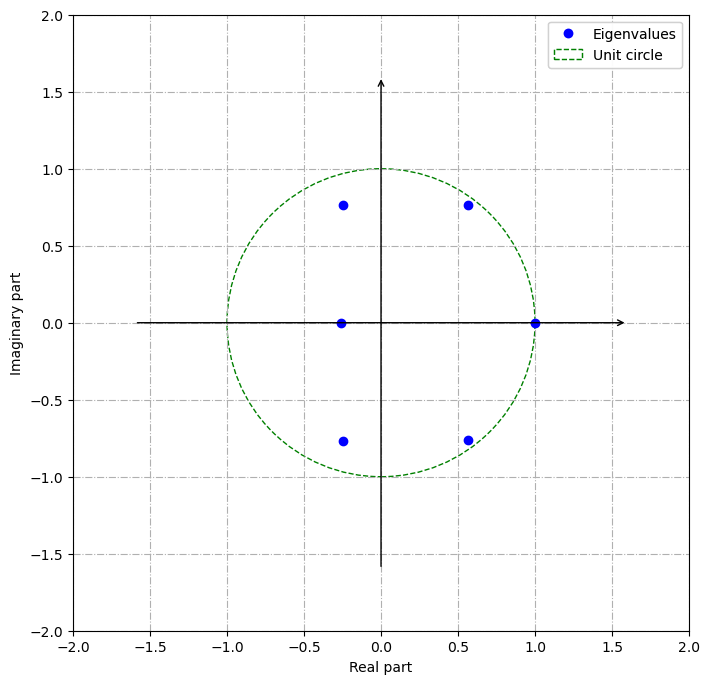

The number of eigenvalues is 6


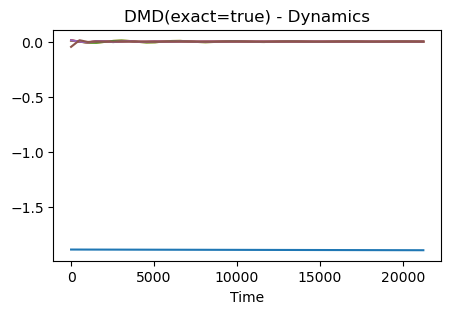

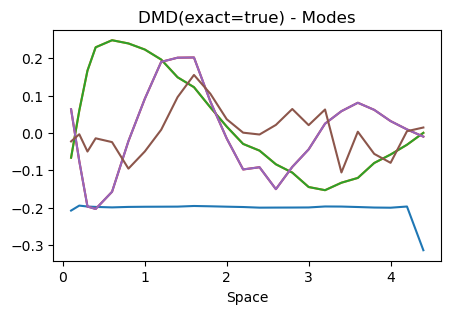

In [15]:

# DMD(exact=true) 

#dmd = DMD(svd_rank=-1)
#dmd = DMD(svd_rank=-1,exact=True)
#dmd = DMD(svd_rank=-1,exact=True,rescale_mode='auto')
dmd = DMD(exact=True)
dmd.fit(X=data)
make_plot(dmd.reconstructed_data.T, x=xlist, y=tlist, title='DMD(exact=true)')


dmd.plot_eigs(show_axes=True, show_unit_circle=True, figsize=(8, 8))

# plot eigenvalues
#dmd.plot_eigs(show_axes=True, show_unit_circle=True, figsize=(8, 8))

# print eigenvalues
print('The number of eigenvalues is {}'.format(dmd.eigs.shape[0]))
#for eig in dmd.eigs:
#    print('Eigenvalue {}: distance from unit circle {}'.format(eig, np.abs(eig.imag**2+eig.real**2 - 1)))


# Plot modes and dynamics 

plt.figure(figsize=(5,3))
for dynamic in dmd.dynamics:
    plt.plot(tlist, dynamic.real)
plt.title('DMD(exact=true) - Dynamics')
plt.xlabel('Time')
plt.show()

plt.figure(figsize=(5,3))
for mode in dmd.modes.T:
    plt.plot(xlist, mode.real)
plt.title('DMD(exact=true) - Modes')
plt.xlabel('Space')
plt.show()

# this does not represnt the dynamics very well

# Using svd_rank and tlsq_rank 

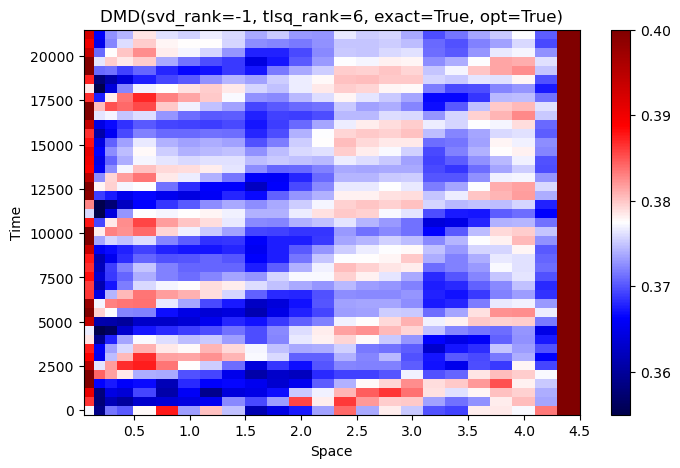

In [16]:

dmd1 = DMD(svd_rank=-1, tlsq_rank=6, exact=True, opt=True)
dmd1.fit(X=data)
make_plot(dmd1.reconstructed_data.T, x=xlist, y=tlist, title='DMD(svd_rank=-1, tlsq_rank=6, exact=True, opt=True)')
#dmd1.plot_modes_2D(figsize=(12,5),x=xlist)



# print eigenvalues

In [17]:

print('The number of eigenvalues is {}'.format(dmd1.eigs.shape[0]))
for eig in dmd1.eigs:
    print('Eigenvalue {}: absolute value {} and distance from unit circle {}'.format(eig, np.abs(eig.imag**2+eig.real**2), np.abs(eig.imag**2+eig.real**2 - 1)))

The number of eigenvalues is 24
Eigenvalue (1.6494315295223185+0j): absolute value 2.720624370582335 and distance from unit circle 1.720624370582335
Eigenvalue (1.0002210997882044+0j): absolute value 1.0004422484615252 and distance from unit circle 0.0004422484615251854
Eigenvalue (0.619573119170092+0.7706442034872915j): absolute value 0.9777633383667188 and distance from unit circle 0.022236661633281196
Eigenvalue (0.619573119170092-0.7706442034872915j): absolute value 0.9777633383667188 and distance from unit circle 0.022236661633281196
Eigenvalue (0.20329391314380374+0.9832522749436445j): absolute value 1.0081134513031726 and distance from unit circle 0.008113451303172647
Eigenvalue (0.20329391314380374-0.9832522749436445j): absolute value 1.0081134513031726 and distance from unit circle 0.008113451303172647
Eigenvalue (-0.3151120299687263+0.8902976769917024j): absolute value 0.8919255450878331 and distance from unit circle 0.10807445491216694
Eigenvalue (-0.3151120299687263-0.89029

# plot eigenvalues

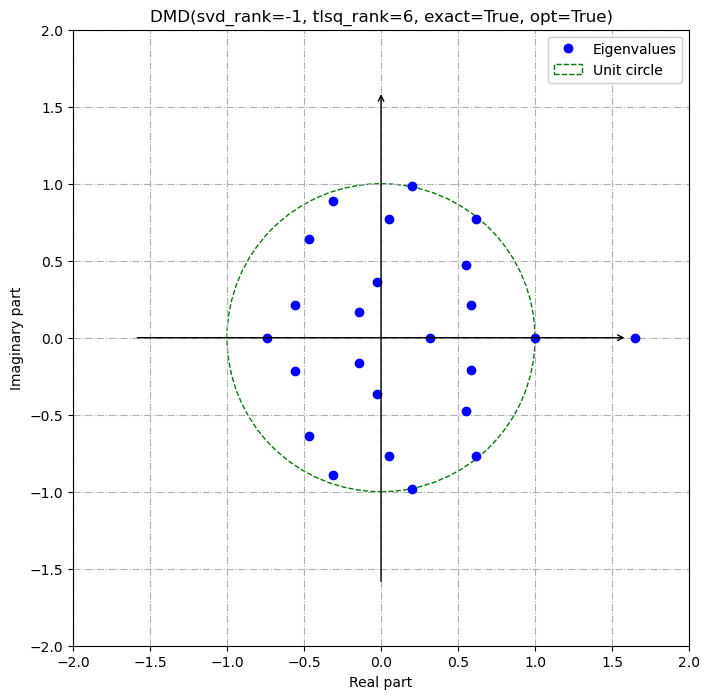

In [18]:
dmd1.plot_eigs(show_axes=True, show_unit_circle=True, figsize=(8, 8),title='DMD(svd_rank=-1, tlsq_rank=6, exact=True, opt=True)')



# plot modes 2-8 and their dynaimcs

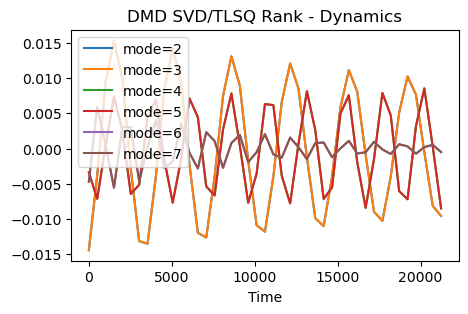

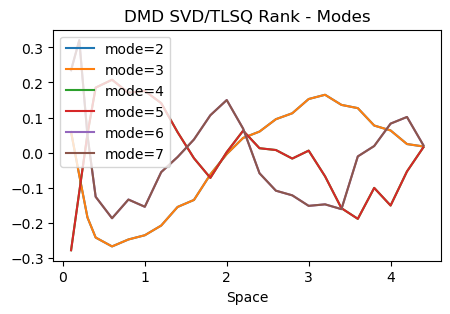

In [19]:
plt.figure(figsize=(5,3))
for i in range(2,8):
    plt.plot(tlist, dmd1.dynamics[i].real,label='mode={:}'.format(i))
plt.title('DMD SVD/TLSQ Rank - Dynamics')
plt.xlabel('Time')
plt.legend()
plt.show()

plt.figure(figsize=(5,3))
for i in range(2,8):
    plt.plot(xlist, dmd1.modes.T[i].real,label='mode={:}'.format(i))
plt.title('DMD SVD/TLSQ Rank - Modes')
plt.xlabel('Space')
plt.legend()
plt.show()



# plot all modes 

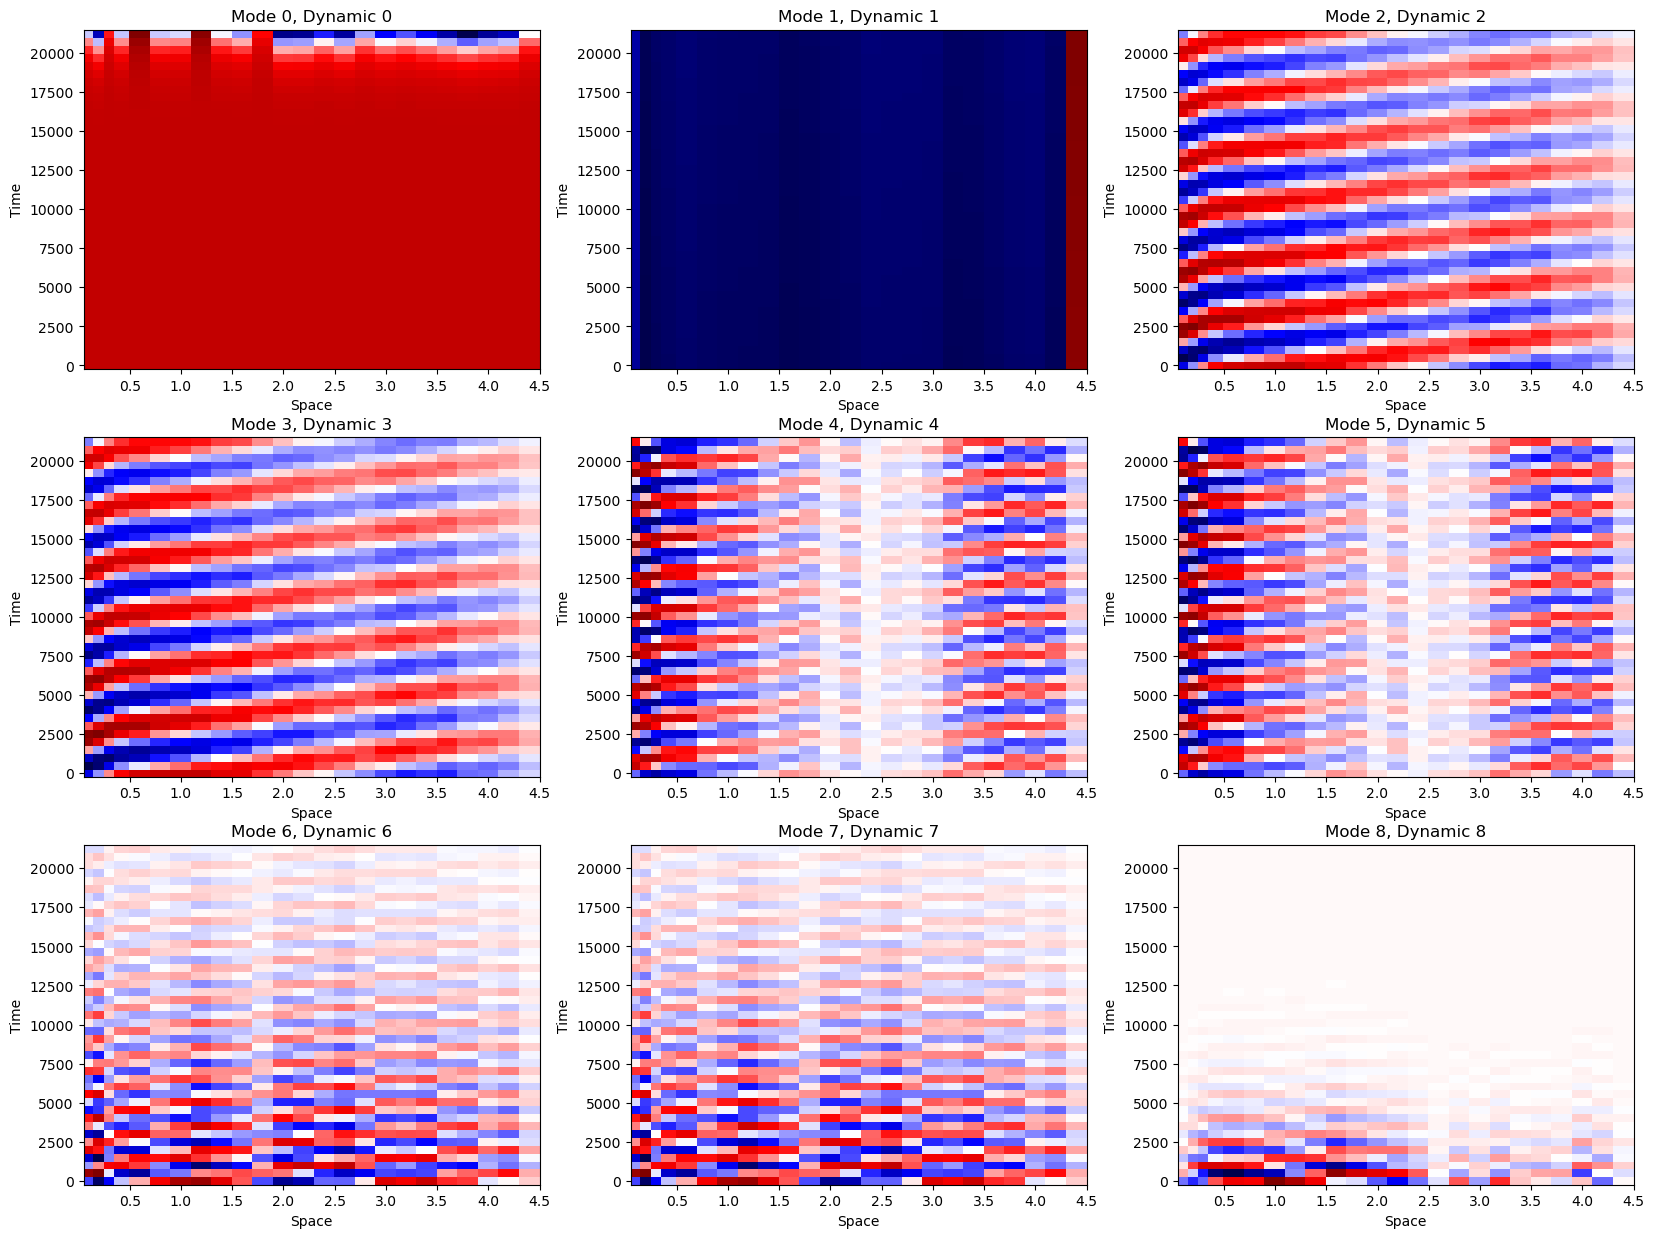

In [20]:


fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(20,15))
modeno=0
for row in ax: 
    for col in row:
       col.pcolor(xlist, tlist, (dmd1.modes.T[modeno].reshape(-1, 1).dot(dmd1.dynamics[modeno].reshape(1, -1))).real.T,cmap='seismic')
       col.set_xlabel('Space')
       col.set_ylabel('Time')
       col.set_title('Mode {0}, Dynamic {0}'.format(modeno))
       modeno+=1
#plt.colorbar()
plt.show()



# Representing data via the first 4 modes

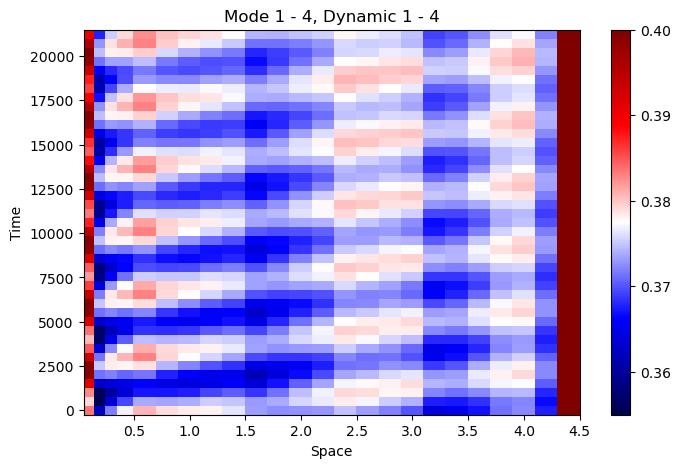

In [21]:

modefrom = 1
modeto = 4

#dmd1mode = (dmd1.modes[modefrom].reshape(-1, 1).dot(dmd1.dynamics[modefrom].reshape(1, -1))).real.T
dmd1mode = (dmd1.modes.T[modefrom].reshape(-1, 1).dot(dmd1.dynamics[modefrom].reshape(1, -1)))

for i in range(modefrom+1,modeto):
#    dmd1mode=dmd1mode+(dmd1.modes[i].reshape(-1, 1).dot(dmd1.dynamics[i].reshape(1, -1))).real.T
    dmd1mode=dmd1mode+(dmd1.modes.T[i].reshape(-1, 1).dot(dmd1.dynamics[i].reshape(1, -1)))

# plot individual modes and dynamics
fig = plt.figure(figsize=(8,5))
plt.pcolor(xlist, tlist, dmd1mode.real.T, vmin=0.355, vmax=0.40, cmap='seismic')
plt.colorbar()
plt.xlabel('Space')
plt.ylabel('Time')
plt.title('Mode {0} - {1}, Dynamic {0} - {1}'.format(modefrom,modeto))
plt.show()